In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.regression import mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('京兴20191209.csv')

label_columns = list(filter(lambda x: 'F_S' in x, df.columns))
input_columns = list(filter(lambda x: 'F_S' not in x, df.columns))
df  = df[df['F_104303.F_S'] != 0]
df  = df[df['F_104304.F_S'] != 0]
X = df.loc[:, input_columns]
X = X.iloc[:, 1:].values
y = df.loc[:, label_columns]
y = y.iloc[:, 0] + y.iloc[:, 1].values

# for i in range(len(X.columns)):
#     X.iloc[:, i: i+1] = MinMaxScaler().fit_transform(X.iloc[:, i: i+1])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2]:
print(y.min(), y.max(), np.mean(y), np.std(y))

1812.5875855 32178.51855 27490.381186096856 5771.471569953804


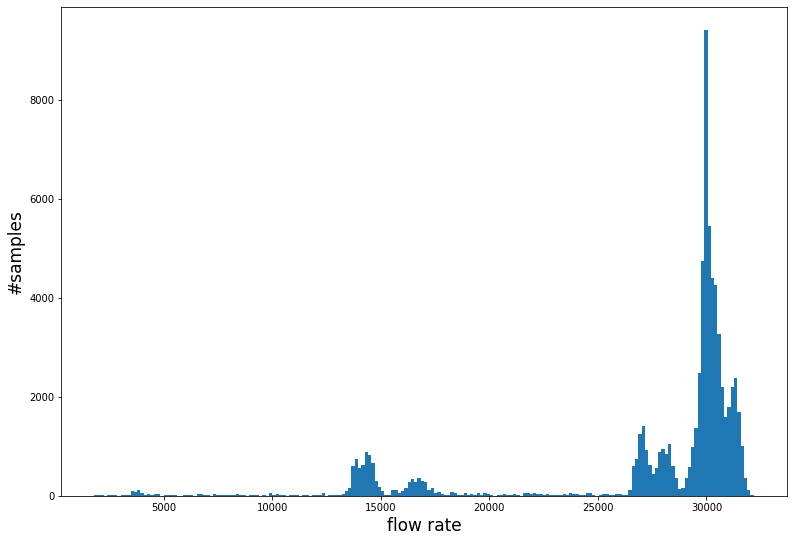

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 9))
plt.hist(y, bins=200)
plt.xlabel('flow rate', fontsize=17)
plt.ylabel('#samples', fontsize=17)
# plt.show()
plt.savefig('fig/fs_distribution.png')

In [6]:
for i in range(X.shape[1]):
    print(np.corrcoef(X[:, i], y)[0, 1])

0.05424852043078665
0.4185024884197063
0.9716861340639668
0.05923563656975621
0.35295044297859846
0.9735321866749705
-0.08889655243340183
0.6280572151728706
nan


In [2]:
print('baseline training mse:', np.std(y_train)**2)
print('baseline testing mse:', np.std(y_test)**2)

baseline training mse: 33161918.048087277
baseline testing mse: 33901106.742943674


In [3]:
print('linear model')
model = LinearRegression().fit(X_train, y_train)
out = model.predict(X_train)
print('training:', mean_squared_error(out, y_train))
out = model.predict(X_test)
print('testing:', mean_squared_error(out, y_test))

linear model
training: 14725.59785831299
testing: 15083.50646876051


In [4]:
model = lgb.LGBMRegressor(silent=False).fit(X_train, y_train)
print('lgb model')
out = model.predict(X_train)
print('training:', mean_squared_error(out, y_train))
out = model.predict(X_test)
print('testing:', mean_squared_error(out, y_test))

lgb model
training: 6546.494862895776
testing: 7143.051551352274


In [5]:
training_data = lgb.Dataset(data=X_train, label=y_train)
testing_data = lgb.Dataset(data=X_test, label=y_test)
params = {'objective':'regression', 'num_iterations':150, 'learning_rate':0.3, 'num_leaves':100000, 'metric':'l2'}
rt = lgb.train(params=params, train_set=training_data, valid_sets=[training_data, testing_data],)

C:\Users\limuf\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's l2: 1.62525e+07	valid_1's l2: 1.6614e+07
[2]	training's l2: 7.96638e+06	valid_1's l2: 8.14418e+06
[3]	training's l2: 3.90589e+06	valid_1's l2: 3.99246e+06
[4]	training's l2: 1.9159e+06	valid_1's l2: 1.95913e+06
[5]	training's l2: 940639	valid_1's l2: 961952
[6]	training's l2: 462608	valid_1's l2: 473459
[7]	training's l2: 228255	valid_1's l2: 233901
[8]	training's l2: 113350	valid_1's l2: 116513
[9]	training's l2: 56961.1	valid_1's l2: 58973
[10]	training's l2: 29250.1	valid_1's l2: 30702.3
[11]	training's l2: 15593.2	valid_1's l2: 16799.2
[12]	training's l2: 8847.08	valid_1's l2: 9962.74
[13]	training's l2: 5490.19	valid_1's l2: 6553.04
[14]	training's l2: 3788.56	valid_1's l2: 4840
[15]	training's l2: 2926.73	valid_1's l2: 3967.43
[16]	training's l2: 2453.08	valid_1's l2: 3473.84
[17]	training's l2: 2189.92	valid_1's l2: 3213.88
[18]	training's l2: 2034.25	valid_1's l2: 3056.02
[19]	training's l2: 1923.42	valid_1's l2: 2944.86
[20]	training's l2: 1844.3	valid_1's l2: 2

In [7]:
rt.save_model('gbdt_model.txt')
